In [3]:
import os
import math
import json
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, hamming_loss, precision_score, recall_score, classification_report
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from tqdm.auto import tqdm

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Device: cuda
GPU: NVIDIA GeForce RTX 5070 Ti Laptop GPU


## Load & Prepare Data

In [4]:
data_path = "dataset_preprocessed_final.csv"
df = pd.read_csv(data_path)

if "text_clean" in df.columns:
    text_col = "text_clean"
elif "text" in df.columns:
    text_col = "text"
else:
    raise ValueError("Tidak ditemukan kolom text_clean maupun text")

label_cols = [c for c in df.columns if c not in [text_col]]

texts_all = df[text_col].astype(str).values
labels_all = df[label_cols].values.astype(np.float32)

print("Total samples:", len(texts_all))
print("Num labels:", len(label_cols))
print("Average labels per sample:", labels_all.sum(axis=1).mean())

Total samples: 57561
Num labels: 28
Average labels per sample: 1.2392939


## Split Data (Train/Val/Test)

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    texts_all,
    labels_all,
    test_size=0.1,
    random_state=seed
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.1,
    random_state=seed
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 46623
Val size: 5181
Test size: 5757


## Model Configuration & Hyperparameters

In [6]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_len = 128
batch_size = 32
epochs = 6
learning_rate = 2e-5
weight_decay = 0.01
warmup_ratio = 0.1
label_smoothing = 0.05

## Dataset Class Definition

In [7]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        labels = torch.tensor(self.labels[index], dtype=torch.float)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

## Create DataLoaders

In [8]:
train_dataset = EmotionDataset(X_train, y_train, tokenizer, max_len)
val_dataset = EmotionDataset(X_val, y_val, tokenizer, max_len)
test_dataset = EmotionDataset(X_test, y_test, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


## RMSNorm Layer

In [9]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        norm = x.pow(2).mean(-1, keepdim=True)
        x = x * torch.rsqrt(norm + self.eps)
        return self.weight * x

## Custom BERT Model Definition

In [10]:
class CustomBertMultiLabel(nn.Module):
    def __init__(self, model_name, num_labels, dropout=0.3, n_dropout=3, num_attn_heads=2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name, output_hidden_states=True)
        hidden_size = self.bert.config.hidden_size
        self.num_layers = self.bert.config.num_hidden_layers
        self.layer_indices = [self.num_layers, max(1, self.num_layers // 2), 1]
        self.layer_weights = nn.Parameter(torch.ones(len(self.layer_indices)))
        self.num_attn_heads = num_attn_heads
        self.attn_heads = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(hidden_size, hidden_size),
                    nn.Tanh(),
                    nn.Linear(hidden_size, 1)
                )
                for _ in range(num_attn_heads)
            ]
        )
        feat_dim = hidden_size * (3 + num_attn_heads)
        self.rms = RMSNorm(feat_dim)
        self.dropout = nn.Dropout(dropout)
        ff_dim = hidden_size * 2
        self.ff_gate = nn.Linear(feat_dim, ff_dim)
        self.ff_value = nn.Linear(feat_dim, ff_dim)
        self.ff2 = nn.Linear(ff_dim, ff_dim)
        self.out_global = nn.Linear(ff_dim, num_labels)
        self.num_labels = num_labels
        self.label_query = nn.Parameter(torch.randn(num_labels, hidden_size) / math.sqrt(hidden_size))
        self.label_ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )
        self.logit_mix = nn.Parameter(torch.tensor(0.0))
        self.n_dropout = n_dropout

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states
        selected = [hidden_states[i] for i in self.layer_indices]
        stack = torch.stack(selected, dim=0)
        w = torch.softmax(self.layer_weights, dim=0).view(-1, 1, 1, 1)
        fused = (w * stack).sum(dim=0)
        cls_token = fused[:, 0]
        mask = attention_mask.unsqueeze(-1).type_as(fused)
        sum_embeddings = (fused * mask).sum(dim=1)
        sum_mask = mask.sum(dim=1).clamp(min=1e-9)
        mean_pool = sum_embeddings / sum_mask
        masked_hidden = fused.masked_fill(mask == 0, -1e4)
        max_pool, _ = masked_hidden.max(dim=1)
        attn_pools = []
        for head in self.attn_heads:
            scores = head(fused).squeeze(-1)
            scores = scores.masked_fill(attention_mask == 0, -1e4)
            weights = torch.softmax(scores, dim=1)
            pooled = torch.bmm(weights.unsqueeze(1), fused).squeeze(1)
            attn_pools.append(pooled)
        if len(attn_pools) > 0:
            attn_cat = torch.cat(attn_pools, dim=1)
        else:
            attn_cat = torch.zeros_like(cls_token)
        features = torch.cat([cls_token, mean_pool, max_pool, attn_cat], dim=1)
        features = self.rms(features)
        logits_global_list = []
        for _ in range(self.n_dropout):
            x = self.dropout(features)
            gate = torch.sigmoid(self.ff_gate(x))
            value = self.ff_value(x)
            h = gate * value
            h = self.dropout(h)
            h = F.silu(self.ff2(h))
            h = self.dropout(h)
            logits_global_list.append(self.out_global(h))
        logits_global = torch.stack(logits_global_list, dim=0).mean(dim=0)
        B, T, H = fused.shape
        queries = self.label_query
        attn_logits = torch.einsum("bth,lh->btl", fused, queries)
        attn_logits = attn_logits.masked_fill(attention_mask.unsqueeze(-1) == 0, -1e4)
        attn_weights = torch.softmax(attn_logits, dim=1)
        label_repr = torch.einsum("bth,btl->blh", fused, attn_weights)
        label_repr_flat = label_repr.reshape(B * self.num_labels, H)
        label_logits_flat = self.label_ff(label_repr_flat)
        logits_label = label_logits_flat.view(B, self.num_labels).contiguous().float()
        mix = torch.sigmoid(self.logit_mix)
        logits = mix * logits_global + (1.0 - mix) * logits_label
        return logits


## Initialize Model, Loss, Optimizer & Scheduler

In [11]:
num_labels = len(label_cols)
model = CustomBertMultiLabel(model_name, num_labels)
model.to(device)

y_train_sum = y_train.sum(axis=0)
num_train_samples = y_train.shape[0]
neg_counts = num_train_samples - y_train_sum
pos_weight = neg_counts / (y_train_sum + 1e-5)
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

total_steps = len(train_loader) * epochs
warmup_steps = int(warmup_ratio * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

use_amp = device.type == "cuda"
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


/tmp/ipykernel_6353/2268796452.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


## Training & Evaluation Functions

In [12]:
def smooth_labels(labels, eps):
    return labels * (1.0 - eps) + 0.5 * eps

def train_epoch(model, dataloader, optimizer, scheduler, criterion, device, epoch, epochs, label_smoothing):
    model.train()
    total_loss = 0.0
    for step, batch in enumerate(
        tqdm(dataloader, total=len(dataloader), desc=f"Train {epoch}/{epochs}", leave=True, ncols=100),
        1
    ):
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)
        labels_smooth = smooth_labels(labels, label_smoothing)
        optimizer.zero_grad()
        if use_amp:
            with torch.cuda.amp.autocast():
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels_smooth)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels_smooth)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        total_loss += loss.item() * input_ids.size(0)
    return total_loss / len(dataloader.dataset)

def eval_epoch(model, dataloader, criterion, device, epoch, epochs, phase, label_smoothing):
    model.eval()
    total_loss = 0.0
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for step, batch in enumerate(
            tqdm(dataloader, total=len(dataloader), desc=f"{phase} {epoch}/{epochs}", leave=True, ncols=100),
            1
        ):
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True)
            labels_smooth = smooth_labels(labels, label_smoothing)
            if use_amp:
                with torch.cuda.amp.autocast():
                    logits = model(input_ids, attention_mask)
                    loss = criterion(logits, labels_smooth)
            else:
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels_smooth)
            probs = torch.sigmoid(logits)
            total_loss += loss.item() * input_ids.size(0)
            all_probs.append(probs.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())
    avg_loss = total_loss / len(dataloader.dataset)
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return avg_loss, all_probs, all_labels

def find_best_thresholds(y_true, y_probs, grid):
    num_labels = y_true.shape[1]
    best_thr = np.zeros(num_labels, dtype=np.float32)
    for j in range(num_labels):
        y_t = y_true[:, j]
        p_j = y_probs[:, j]
        best_f1 = 0.0
        best_t = 0.5
        for thr in grid:
            pred = (p_j >= thr).astype(int)
            f1 = f1_score(y_t, pred, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = thr
        best_thr[j] = best_t
    return best_thr

## Initialize Training Variables

In [13]:
threshold_grid = np.arange(0.2, 0.81, 0.05)

best_val_f1 = 0.0
best_state_dict = None
best_thresholds = None
history = []

## Training Loop

In [14]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion, device, epoch, epochs, label_smoothing)
    val_loss, val_probs, val_true = eval_epoch(model, val_loader, criterion, device, epoch, epochs, "Val", label_smoothing)
    thr_vec = find_best_thresholds(val_true, val_probs, threshold_grid)
    val_pred = (val_probs >= thr_vec[None, :]).astype(int)
    f1_macro = f1_score(val_true, val_pred, average="macro", zero_division=0)
    elapsed = time.time() - start_time
    print(
        "Epoch",
        epoch,
        "train_loss",
        round(train_loss, 4),
        "val_loss",
        round(val_loss, 4),
        "val_f1_macro",
        round(f1_macro, 4),
        "time",
        round(elapsed, 1),
        "s"
    )
    history.append(
        {
            "epoch": int(epoch),
            "train_loss": float(train_loss),
            "val_loss": float(val_loss),
            "val_f1_macro": float(f1_macro)
        }
    )
    if f1_macro > best_val_f1:
        best_val_f1 = f1_macro
        best_state_dict = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_thresholds = thr_vec.copy()

Train 1/6:   0%|                                                           | 0/1457 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val 1/6:   0%|                                                              | 0/162 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val 1/6: 100%|████████████████████████████████████████████████████| 162/162 [00:04<00:00, 32.81it/s]


Epoch 1 train_loss 1.7831 val_loss 1.6877 val_f1_macro 0.1806 time 141.9 s


Train 2/6:   0%|                                                           | 0/1457 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val 2/6:   0%|                                                              | 0/162 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val 2/6: 100%|████████████████████████████████████████████████████| 162/162 [00:07<00:00, 21.26it/s]


Epoch 2 train_loss 1.6578 val_loss 1.6286 val_f1_macro 0.2463 time 191.7 s


Train 3/6:   0%|                                                           | 0/1457 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val 3/6:   0%|                                                              | 0/162 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val 3/6: 100%|████████████████████████████████████████████████████| 162/162 [00:08<00:00, 19.15it/s]


Epoch 3 train_loss 1.6244 val_loss 1.608 val_f1_macro 0.2638 time 237.3 s


Train 4/6:   0%|                                                           | 0/1457 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val 4/6:   0%|                                                              | 0/162 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val 4/6: 100%|████████████████████████████████████████████████████| 162/162 [00:08<00:00, 19.30it/s]


Epoch 4 train_loss 1.6083 val_loss 1.5971 val_f1_macro 0.2762 time 254.0 s


Train 5/6:   0%|                                                           | 0/1457 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val 5/6:   0%|                                                              | 0/162 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val 5/6: 100%|████████████████████████████████████████████████████| 162/162 [00:08<00:00, 18.28it/s]


Epoch 5 train_loss 1.5993 val_loss 1.5911 val_f1_macro 0.2814 time 274.6 s


Train 6/6:   0%|                                                           | 0/1457 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val 6/6:   0%|                                                              | 0/162 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val 6/6: 100%|████████████████████████████████████████████████████| 162/162 [00:09<00:00, 17.45it/s]


Epoch 6 train_loss 1.595 val_loss 1.5895 val_f1_macro 0.2854 time 282.9 s


## Load Best Model & Prepare for Testing

In [15]:
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

if best_thresholds is None:
    best_thresholds = np.full(len(label_cols), 0.5, dtype=np.float32)

print("Best validation F1 macro:", round(best_val_f1, 4))
print("Best thresholds:", best_thresholds)

Best validation F1 macro: 0.2854
Best thresholds: [0.8  0.8  0.8  0.75 0.65 0.8  0.8  0.8  0.8  0.75 0.75 0.8  0.8  0.8
 0.8  0.8  0.2  0.8  0.8  0.8  0.8  0.8  0.65 0.8  0.8  0.8  0.8  0.6 ]


## Test Evaluation

In [16]:
test_loss, test_probs, test_true = eval_epoch(model, test_loader, criterion, device, 0, 0, "Test", label_smoothing)
test_pred = (test_probs >= best_thresholds[None, :]).astype(int)

test_f1_macro = f1_score(test_true, test_pred, average="macro", zero_division=0)
test_f1_micro = f1_score(test_true, test_pred, average="micro", zero_division=0)
subset_acc = accuracy_score(test_true, test_pred)
label_acc = 1.0 - hamming_loss(test_true, test_pred)

print("Test loss:", round(test_loss, 4))
print("Test F1 macro:", round(test_f1_macro, 4))
print("Test F1 micro:", round(test_f1_micro, 4))
print("Subset accuracy:", round(subset_acc, 4))
print("Label-wise accuracy:", round(label_acc, 4))

Test 0/0:   0%|                                                             | 0/180 [00:00<?, ?it/s]/tmp/ipykernel_6353/1389919171.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Test 0/0: 100%|███████████████████████████████████████████████████| 180/180 [00:09<00:00, 18.39it/s]

Test loss: 1.5932
Test F1 macro: 0.2801
Test F1 micro: 0.2076
Subset accuracy: 0.0
Label-wise accuracy: 0.8177


## Per-Emotion Metrics

In [17]:
per_f1 = f1_score(test_true, test_pred, average=None, zero_division=0)
per_prec = precision_score(test_true, test_pred, average=None, zero_division=0)
per_rec = recall_score(test_true, test_pred, average=None, zero_division=0)

rows = []
for idx, emo in enumerate(label_cols):
    rows.append(
        {
            "emotion": emo,
            "f1": float(per_f1[idx]),
            "precision": float(per_prec[idx]),
            "recall": float(per_rec[idx])
        }
    )

metrics_df = pd.DataFrame(rows).sort_values("f1", ascending=False)
print("Top 10 emotions by F1:")
print(metrics_df.head(10))

Top 10 emotions by F1:
       emotion        f1  precision    recall
15   gratitude  0.761795   0.692469  0.846547
18        love  0.581064   0.452525  0.811594
1    amusement  0.522472   0.463840  0.598071
7    curiosity  0.503525   0.390625  0.708215
0   admiration  0.486763   0.462662  0.513514
20    optimism  0.364486   0.325905  0.413428
27     neutral  0.333197   0.235362  0.570225
2        anger  0.330413   0.235714  0.552301
6    confusion  0.310857   0.212500  0.578723
3    annoyance  0.305113   0.246947  0.399123


## Confusion Matrix

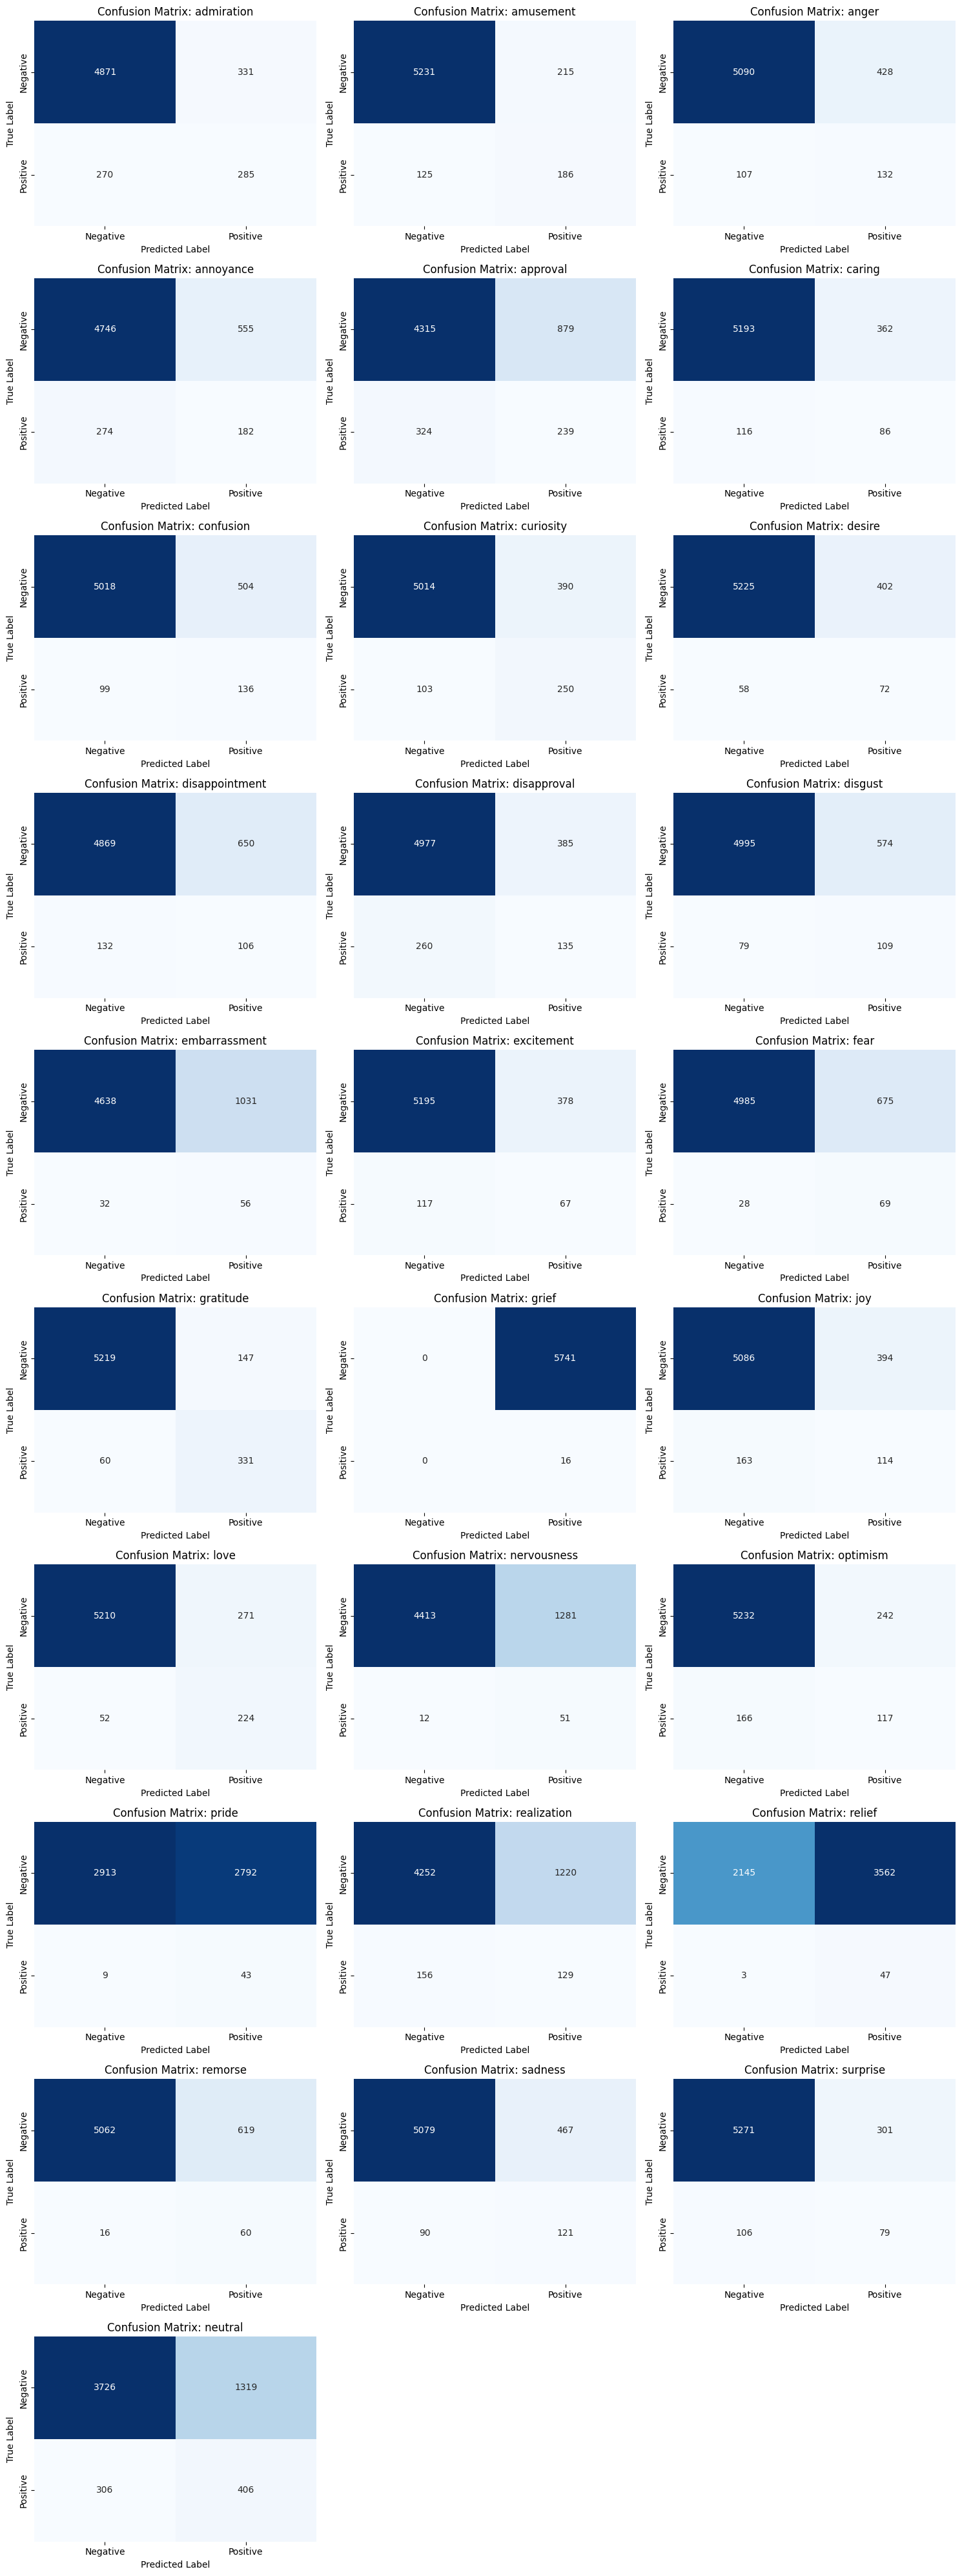

Confusion matrices saved to: output2/confusion_matrices_ourbert.png


In [23]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrices for each label
confusion_matrices = multilabel_confusion_matrix(test_true, test_pred)

# Plot confusion matrix for each emotion
n_labels = len(label_cols)
n_cols = 3
n_rows = (n_labels + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for idx, (cm, label) in enumerate(zip(confusion_matrices, label_cols)):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    ax.set_title(f'Confusion Matrix: {label}')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

# Hide extra subplots
for idx in range(n_labels, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(os.path.join('output2', 'confusion_matrices_ourbert.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices saved to:", os.path.join('output2', 'confusion_matrices_ourbert.png'))

## Save Model & Results

In [ ]:
output_dir = "./output2"
os.makedirs(output_dir, exist_ok=True)

model_output_path = os.path.join(output_dir, "custom_bert_emotion_model.pt")
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "model_name": model_name,
        "num_labels": len(label_cols),
        "max_len": max_len,
        "label_cols": label_cols,
        "thresholds": best_thresholds.tolist()
    },
    model_output_path
)

history_path = os.path.join(output_dir, "training_history.json")
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)

summary = {
    "best_val_f1_macro": float(best_val_f1),
    "test_loss": float(test_loss),
    "test_f1_macro": float(test_f1_macro),
    "test_f1_micro": float(test_f1_micro),
    "subset_accuracy": float(subset_acc),
    "label_accuracy": float(label_acc),
    "num_labels": int(len(label_cols)),
    "num_train": int(len(X_train)),
    "num_val": int(len(X_val)),
    "num_test": int(len(X_test))
}

summary_path = os.path.join(output_dir, "model_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

metrics_json_path = os.path.join(output_dir, "emotion_metrics.json")
metrics_df.to_json(metrics_json_path, orient="records", indent=2)

metrics_csv_path = os.path.join(output_dir, "emotion_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)

print("Saved model to:", model_output_path)
print("Saved training history to:", history_path)
print("Saved summary to:", summary_path)
print("Saved per-emotion metrics to:", metrics_json_path, "and", metrics_csv_path)


Saved model to: ./output2/custom_bert_emotion_model.pt
Saved training history to: ./output2/training_history.json
Saved summary to: ./output2/model_summary.json
Saved per-emotion metrics to: ./output2/emotion_metrics.json and ./output2/emotion_metrics.csv
